In [50]:
import pandas as pd
import numpy as np
import multiprocessing
from nltk.tokenize import word_tokenize
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import fasttext
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, MaxPooling1D, Conv1D
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import gensim
from keras.preprocessing.sequence import pad_sequences
import keras
from keras import backend
import json, multiprocessing
from gensim.test.utils import get_tmpfile

In [2]:
# Perform data cleaning by handling duplicates and missing values.
def data_cleaning(data):
    
    print("There are " + str(len(data)) + " reviews in this dataset.\n")
    print("Let's print out the first few lines to see what the data looks like.\n")
    print(data.head())
    print("\nChecking data types for variables... \n")
    print(data.dtypes)
    
    # Remove duplicate values
    print("\nChecking for duplicates values in 'description' (reviews)...\n")
    print(data.description.describe())
    # Since the duplicated() method returns False for duplicates, the NOT of the series yields unique values in dataset.
    # Making a bool series 
    bool_series = data["description"].duplicated(keep = False) 
    # Passing NOT of bool series to see unique values only  
    data = data[~bool_series] 
    print("Duplicates removed. \n")
    
    # Handle missing values and data imputation
    print("Checking for missing values in reviews...\n")
    print(data.isnull().sum().sort_values(ascending = False))
    # Remove specific regions "region_1", "region_2", "designation" regarding wine growing area since province also provides geographical information while having much less missing values.
    # Remove vairables "taster_name", "taster_twitter_handle" by assuming the objectivity of scoring and reviews. In addition, we will not further collect data through Twitter API.
    data = data.drop(["region_1", "region_2", "designation", "taster_name", "taster_twitter_handle"], axis =1)
    print("\nColumns 'region_1', 'region_2', 'designation', 'taster_name', 'taster_twitter_handle' are dropped.\n")
    # Rows that have null values in columns 'province', 'country', and 'variety' are dropped.
    data = data.dropna(subset=['province', 'country', 'variety'])
    print("Rows that have null values in columns 'province', 'country', and 'variety' are dropped.\n")
    # Replace null prices with the mean
    print("Replace null prices with the mean value.\n")
    data["price"] = data["price"].fillna(data["price"].mean())
    print(data.isnull().sum(), "\n\n Data imputation completed. \n")
    
    return data

In [3]:
# Extract top N wine varieties and keep only records with those varieties in current dataset.
def top_variety_extraction(data, n):
    
    # Prepare the reviews dataset
    data = data[["description", "variety"]]
    # Count the total number of wine variety
    print("Number of wine variety: ", data['variety'].nunique(), "\n")
    count_variety = data.variety.value_counts()
    # Take top N varieties with the most occurances
    topN_distribution = count_variety.head(n) 
    # Only keep records with variety in this list
    topN_bool = data["variety"].isin(topN_distribution.index.to_list())
    data = data[topN_bool].reset_index(drop = True)
    print("We choose to keep top", n, "varieties with the most occurances since there are hundreds of labels.")
    
    return data, topN_distribution

In [4]:
# The summary statistics for dataset which includes the number of reviews, the number of labels, label distribution, average / mean word length of documents.
def summary_statistics(data, labels):
    
    # Number of reviews
    num_doc = len(data)
    # Number of labels
    num_labels = len(set(labels.index.to_list()))
    # Average / mean word length of documents
    text_ls = []
    label_ls = []
    doc_len_ls = []
    for i in range(len(data)):
        text = data.iloc[i].description
        label = data.iloc[i].variety
        text_ls.append(text)
        label_ls.append(label)
        doc_len_ls.append(len(word_tokenize(text)))
    avg_len = mean(doc_len_ls)
    print("Number of reviews: ", num_doc)
    print("Number of labels: ", num_labels)
    print("Label distribution: \n", labels)
    print("Average word length of reviews: ", avg_len)
    
    return text_ls, label_ls

In [5]:
# Helper function for tokenization
def tokenization(text, stopwords):
    
    # Apply nltk word tokenization, convert to lower cases, remove non-alphabetic chars and stopwords.
    review_tokenized = [i.lower() for i in word_tokenize(text) if i.isalpha() and i not in stopwords]
    
    return review_tokenized

# Apply nltk word tokenization, convert to lower cases, remove non-alphabetic chars and stopwords.
def review_processing(labels, texts):
    
    # Remove list of stopwords that do not add much meaning to a sentence.
    stop_words = set(stopwords.words('english'))
    texts_tokenized = [tokenization(i, stop_words) for i in texts]
    cleaned_df = pd.DataFrame({'text': texts_tokenized, 'label': labels})
    # Double check to remove null values.
    cleaned_df = cleaned_df.dropna()
    
    return cleaned_df

In [6]:
# Split dataset into training and testing sets.
def split_data(data): 
    X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size = 0.3, random_state = 42)
    return X_train, X_test, y_train, y_test

In [7]:
# Apply TfidfVectorizer to transform text into feature vectors that can be used as input to estimator. 
def tfidf_transform(train, test, min_df, max_df, ngram):
    # Sublinear tf scaling replaces tf with 1 + log(tf), addressing the problem that 20 occurrences of a word is probably not 20 times more important than 1 occurrence.
    tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, min_df = min_df, max_df = max_df, ngram_range = ngram)
    features_train = tfidf_vectorizer.fit_transform(train)
    features_test = tfidf_vectorizer.transform(test)
    return features_train, features_test

In [8]:
# Performance evaluation metrics.
def score_metrics(test, pred):
    print("Precision:", precision_score(test, pred, average='macro'))
    print("Recall: ", recall_score(test, pred, average='macro'))
    print("F1 score: ", f1_score(test, pred, average='macro'))
    print("Accuracy: ", accuracy_score(test, pred))
    print("Micro-averaged F1-score: ", f1_score(test, pred, average = 'macro'))

In [9]:
# main
# import data
data = pd.read_csv("winemag-data-130k-v2.csv", index_col = 0)
cleaned_data = data_cleaning(data)

There are 129971 reviews in this dataset.

Let's print out the first few lines to see what the data looks like.

    country                                        description  \
0     Italy  Aromas include tropical fruit, broom, brimston...   
1  Portugal  This is ripe and fruity, a wine that is smooth...   
2        US  Tart and snappy, the flavors of lime flesh and...   
3        US  Pineapple rind, lemon pith and orange blossom ...   
4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region

In [10]:
data.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [11]:
# Keep top 10 varieties with the most occurances.
topN_data, labels = top_variety_extraction(cleaned_data, 10)

Number of wine variety:  686 

We choose to keep top 10 varieties with the most occurances since there are hundreds of labels.


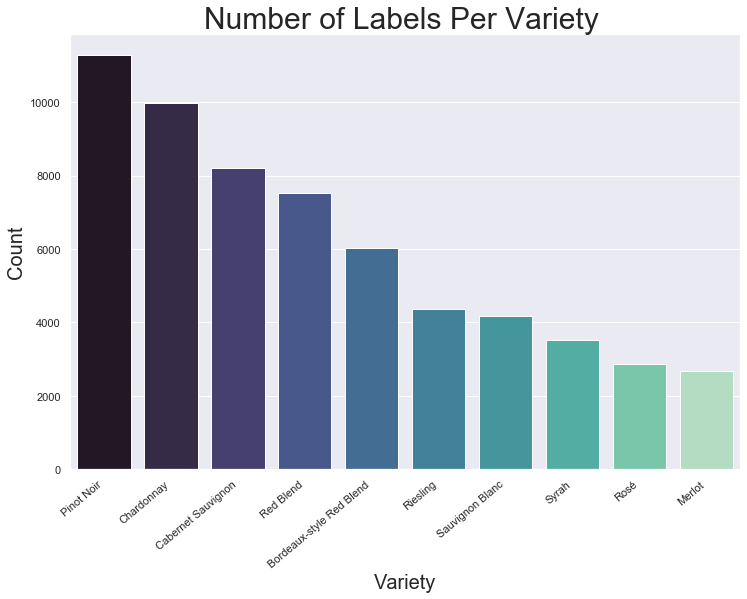

In [12]:
# Label distribution visualization.
sns.set(rc = {'figure.figsize':(12, 8)})
chart = sns.countplot(topN_data.variety, palette = "mako", order = topN_data['variety'].value_counts().index)
plt.title("Number of Labels Per Variety ", fontsize = 30)
chart.set_xlabel("Variety", fontsize = 20)
chart.set_ylabel("Count", fontsize = 20)
chart.set_xticklabels(chart.get_xticklabels(), rotation = 40, horizontalalignment = 'right');

In [13]:
text_ls, label_ls = summary_statistics(topN_data, labels)

Number of reviews:  60612
Number of labels:  10
Label distribution: 
 Pinot Noir                  11280
Chardonnay                   9977
Cabernet Sauvignon           8199
Red Blend                    7525
Bordeaux-style Red Blend     6023
Riesling                     4356
Sauvignon Blanc              4178
Syrah                        3511
Rosé                         2875
Merlot                       2688
Name: variety, dtype: int64
Average word length of reviews:  47.71956048307266


In [14]:
processed_data = review_processing(label_ls, text_ls)

In [15]:
print("The first 10 rows of processed dataset: \n", processed_data.head(10))

The first 10 rows of processed dataset: 
                                                 text            label
0  [pineapple, rind, lemon, pith, orange, blossom...         Riesling
1  [much, like, regular, bottling, comes, across,...       Pinot Noir
2  [zesty, orange, peels, apple, notes, abound, s...         Riesling
3  [ripe, aromas, dark, berries, mingle, ample, n...        Red Blend
4  [a, sleek, mix, tart, berry, stem, herb, along...       Pinot Noir
5  [oak, earth, intermingle, around, robust, arom...       Pinot Noir
6  [aromas, suggest, mature, berry, scorched, ear...        Red Blend
7  [merlot, nero, form, base, easy, red, wine, wo...        Red Blend
8  [rustic, dry, flavors, berries, currants, lico...        Red Blend
9  [this, shows, tart, green, gooseberry, flavor,...  Sauvignon Blanc


In [16]:
processed_data.to_csv('cleaned_reviews.csv')
print("Cleaned dataframe successfully saved into CSV as 'cleaned_reviews.csv'")

Cleaned dataframe successfully saved into CSV as 'cleaned_reviews.csv'


In [17]:
# Read data in from CSV so that tokenized word lists are converted to str format, preparing for fit_transform in vectorization.
df = pd.read_csv("cleaned_reviews.csv")
df = df.drop('Unnamed: 0', axis = 1)

In [18]:
# Split data into test and train sets
X_train, X_test, y_train, y_test = split_data(df)

In [19]:
# Apply TfidfVectorizer to transform text into feature vectors that can be used as input to estimator. 
# Set max_df = 0.90 so as to ignore terms that appear in more than 90% of the documents.
# Set min_df = 50 so as to ignore terms that appear in less than 50 documents.
# 1gram transformed data
train_x_1gram, test_x_1gram = tfidf_transform(X_train, X_test, min_df = 50, max_df = 0.90, ngram = (1,1))
# 1gram+2gram transformed data
train_x_1gram2gram, test_x_1gram2gram = tfidf_transform(X_train, X_test, min_df = 50, max_df = 0.90, ngram = (1,2)) 

In [20]:
# 1. Logistic Regression

# 1gram, C = 1
print("Results for 1gram with C = 1 (default): ")
# For parameter multi_class, if the option chosen is ‘ovr’, then a binary problem is fit for each label.
# For parameter C, it stands for inverse of regularization strength; smaller values specify stronger regularization.
lr1 = LogisticRegression(C = 1, penalty = 'l2', max_iter = 100, random_state = 42, multi_class = 'ovr')
model1 = lr1.fit(train_x_1gram, y_train)
pred1 = model1.predict(test_x_1gram)
score_metrics(y_test, pred1)

Results for 1gram with C = 1 (default): 
Precision: 0.7942627513675696
Recall:  0.7188607772010857
F1 score:  0.7428031464836504
Accuracy:  0.7700175978882534
Micro-averaged F1-score:  0.7428031464836504


In [21]:
# 1gram, C = 0.5
print("Results for 1gram with C = 0.5: ")
lr2 = LogisticRegression(C = 0.5, penalty = 'l2', max_iter = 100, random_state = 42, multi_class = 'ovr')
model2 = lr2.fit(train_x_1gram, y_train)
pred2 = model2.predict(test_x_1gram)
score_metrics(y_test, pred2)

Results for 1gram with C = 0.5: 
Precision: 0.8000658603920044
Recall:  0.7079526055001143
F1 score:  0.7351014578688708
Accuracy:  0.7649032116146063
Micro-averaged F1-score:  0.7351014578688708


In [22]:
# 1gram+2gram, C = 1
print("Results for 1gram+2gram with C = 1 (default): ")
lr3 = LogisticRegression(C = 1, penalty = 'l2', max_iter = 100, random_state = 42, multi_class = 'ovr')
model3 = lr3.fit(train_x_1gram2gram, y_train)
pred3 = model3.predict(test_x_1gram2gram)
score_metrics(y_test, pred3)

Results for 1gram+2gram with C = 1 (default): 
Precision: 0.8016626612779161
Recall:  0.7205226292472924
F1 score:  0.745735244442101
Accuracy:  0.773152221733392
Micro-averaged F1-score:  0.745735244442101


In [23]:
# 1gram+2gram, C = 0.5
print("Results for 1gram+2gram with C = 0.5: ")
lr4 = LogisticRegression(C = 0.5, penalty = 'l2', max_iter = 100, random_state = 42, multi_class = 'ovr')
model4 = lr4.fit(train_x_1gram2gram, y_train)
pred4 = model4.predict(test_x_1gram2gram)
score_metrics(y_test, pred4)

Results for 1gram+2gram with C = 0.5: 
Precision: 0.8050652992881837
Recall:  0.7055834245164656
F1 score:  0.7339278828615952
Accuracy:  0.7652331720193577
Micro-averaged F1-score:  0.7339278828615952


In [24]:
# 2. SVM

# 1gram, C = 1, loss = hinge
print("Results for 1gram with C = 1 (default) and loss = hinge: ")
svm1 = LinearSVC(C = 1, loss = 'hinge', random_state = 42)
model1 = svm1.fit(train_x_1gram, y_train)
pred1 = model1.predict(test_x_1gram)
score_metrics(y_test, pred1)

Results for 1gram with C = 1 (default) and loss = hinge: 
Precision: 0.770376526671852
Recall:  0.7261278340340434
F1 score:  0.7414931007943416
Accuracy:  0.7680378354597448
Micro-averaged F1-score:  0.7414931007943416


In [25]:
# 1gram, C = 1, loss = squared_hinge
print("Results for 1gram with C = 1 (default) and loss = squared_hinge: ")
svm2 = LinearSVC(C = 1, loss = 'squared_hinge', random_state = 42)
model2 = svm2.fit(train_x_1gram, y_train)
pred2 = model2.predict(test_x_1gram)
score_metrics(y_test, pred2)

Results for 1gram with C = 1 (default) and loss = squared_hinge: 
Precision: 0.765109656015204
Recall:  0.7269123619422821
F1 score:  0.741172153848428
Accuracy:  0.7674329080510339
Micro-averaged F1-score:  0.741172153848428


In [26]:
# 1gram, C = 0.5, loss = squared_hinge
print("Results for 1gram with C = 0.5 and loss = squared_hinge: ")
svm3 = LinearSVC(C = 0.5, loss = 'squared_hinge', random_state = 42)
model3 = svm3.fit(train_x_1gram, y_train)
pred3 = model3.predict(test_x_1gram)
score_metrics(y_test, pred3)

Results for 1gram with C = 0.5 and loss = squared_hinge: 
Precision: 0.7754149296070498
Recall:  0.7289762634628475
F1 score:  0.7455851641493958
Accuracy:  0.7712274527056753
Micro-averaged F1-score:  0.7455851641493958


In [27]:
# 1gram+2gram, C = 1, loss = hinge
print("Results for 1gram+2gram with C = 1 (default) and loss = hinge: ")
svm4 = LinearSVC(C = 1, loss = 'hinge', random_state = 42)
model4 = svm4.fit(train_x_1gram2gram, y_train)
pred4 = model4.predict(test_x_1gram2gram)
score_metrics(y_test, pred4)

Results for 1gram+2gram with C = 1 (default) and loss = hinge: 
Precision: 0.7707159254012571
Recall:  0.7262114626170162
F1 score:  0.7416517825237868
Accuracy:  0.7688627364716234
Micro-averaged F1-score:  0.7416517825237868


In [28]:
# 1gram+2gram, C = 1, loss = squared_hinge
print("Results for 1gram+2gram with C = 1 (default) and loss = squared_hinge: ")
svm5 = LinearSVC(C = 1, loss = 'squared_hinge', random_state = 42)
model5 = svm5.fit(train_x_1gram2gram, y_train)
pred5 = model5.predict(test_x_1gram2gram)
score_metrics(y_test, pred5)

Results for 1gram+2gram with C = 1 (default) and loss = squared_hinge: 
Precision: 0.7601336212686178
Recall:  0.7277973309997148
F1 score:  0.7403406012327195
Accuracy:  0.7661680598328201
Micro-averaged F1-score:  0.7403406012327195


In [29]:
# 1gram+2gram, C = 0.5, loss = squared_hinge
print("Results for 1gram+2gram with C = 0.5 and loss = squared_hinge: ")
svm6 = LinearSVC(C = 0.5, loss = 'squared_hinge', random_state = 42)
model6 = svm6.fit(train_x_1gram2gram, y_train)
pred6 = model6.predict(test_x_1gram2gram)
score_metrics(y_test, pred6)

Results for 1gram+2gram with C = 0.5 and loss = squared_hinge: 
Precision: 0.7738184916642525
Recall:  0.7299463175485849
F1 score:  0.7457745074462696
Accuracy:  0.7715574131104268
Micro-averaged F1-score:  0.7457745074462696


In [30]:
# 3. Fasttext

# Fasttext data preparation. 
def fasttext_data_prep(labels, texts):

    fasttext_df = pd.DataFrame({'text': texts, 'label': labels})
    # Add __label__ prefix in front of all labels.
    fasttext_df['label'] = '__label__'+  fasttext_df['label'].astype(str)
    # Convert to lower cases, remove stopwords, and non-alphabetical chars.
    stop_words = set(stopwords.words('english'))
    fasttext_df['text'] = fasttext_df.apply(lambda x: ' '.join(i.lower() for i in x['text'].split() if i.isalpha() and i not in stop_words), axis = 1)
    # Combine these two columns into our new labels in format: __label__ text.
    fasttext_df['new_label'] = fasttext_df.apply(lambda x: str(x['label']) + ' ' + str(x['text']), axis = 1)
    print("The first 10 rows of fasttext dataset: \n", fasttext_df.head(10))
    
    return fasttext_df

In [31]:
# Fasttext performance evaluation metrics.
def fasttext_metrics(evaluation):
    precision = evaluation[1]
    recall = evaluation[2]
    f1 = 2*precision*recall / (precision+recall)
    print("Precision:", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1)

In [32]:
# Data preparation.
fasttext_df = fasttext_data_prep(label_ls, text_ls)
# Split into testing and training sets.
X_train, X_test, y_train, y_test = train_test_split(fasttext_df['new_label'], fasttext_df['label'], test_size = 0.3, random_state = 42)
# Saving testing and training data into txt file for uniform formatting.
X_train.to_csv('fasttext_X_train.txt',index = False, header = False)
X_test.to_csv('fasttext_X_test.txt',index = False, header = False)


The first 10 rows of fasttext dataset: 
                                                 text  \
0  pineapple lemon pith orange blossom start the ...   
1  much like regular bottling comes across rather...   
2  zesty orange peels apple notes abound off dry ...   
3  ripe aromas dark berries mingle ample notes bl...   
4  a sleek mix tart stem along hint oak fair valu...   
5  oak earth intermingle around robust aromas wet...   
6  aromas suggest mature scorched toast the palat...   
7  merlot nero form base easy red wine would pair...   
8  rustic flavors licorice made cabernet franc ca...   
9  this shows green gooseberry flavor similar new...   

                      label                                          new_label  
0         __label__Riesling  __label__Riesling pineapple lemon pith orange ...  
1       __label__Pinot Noir  __label__Pinot Noir much like regular bottling...  
2         __label__Riesling  __label__Riesling zesty orange peels apple not...  
3        __label__

In [33]:
# lr = 1.0, wordNgrams = 1
fasttext1 = fasttext.train_supervised('fasttext_X_train.txt', lr = 1.0, wordNgrams = 1, epoch = 25)                                       
evaluation1 = fasttext1.test('fasttext_X_test.txt')
fasttext_metrics(evaluation1)

Precision: 0.9274637043554773
Recall:  0.9274637043554773
F1 score:  0.9274637043554773


In [34]:
# lr = 1.0, wordNgrams = 2
fasttext2 = fasttext.train_supervised('fasttext_X_train.txt', lr = 1.0, wordNgrams = 2, epoch = 25)                                       
evaluation2 = fasttext2.test('fasttext_X_test.txt')
fasttext_metrics(evaluation2)

Precision: 0.9385173779146503
Recall:  0.9385173779146503
F1 score:  0.9385173779146503


In [35]:
# lr = 0.5, wordNgrams = 2
fasttext3 = fasttext.train_supervised('fasttext_X_train.txt', lr = 0.5, wordNgrams = 2, epoch = 25)                                       
evaluation3 = fasttext3.test('fasttext_X_test.txt')
fasttext_metrics(evaluation3)

Precision: 0.9392872855257369
Recall:  0.9392872855257369
F1 score:  0.9392872855257369


In [36]:
# lr = 0.05, wordNgrams = 2
fasttext4 = fasttext.train_supervised('fasttext_X_train.txt', lr = 0.05, wordNgrams = 2, epoch = 25)                                       
evaluation4 = fasttext4.test('fasttext_X_test.txt')
fasttext_metrics(evaluation4)

Precision: 0.9397822261328641
Recall:  0.9397822261328641
F1 score:  0.9397822261328641


In [37]:
# 4. CNN
# Referencing code from lecture5.py

def token_to_index(token, dictionary):
    """
    Given a token and a gensim dictionary, return the token index
    if in the dictionary, None otherwise.
    Reserve index 0 for padding.
    """
    if token not in dictionary.token2id:
        return None
    return dictionary.token2id[token] + 1


def texts_to_indices(text, dictionary):
    """
    Given a list of tokens (text) and a gensim dictionary, return a list
    of token ids.
    """
    result = list(map(lambda x: token_to_index(x, dictionary), text))
    return list(filter(None, result))


def train(train_texts, train_labels, dictionary, model_file = None, EMBEDDINGS_MODEL_FILE = None):
    """
    Train a word-level CNN text classifier.
    :param train_texts: tokenized and normalized texts, a list of token lists, [['sentence', 'blah', 'blah'], ['sentence', '2'], .....]
    :param train_labels: the label for each train text
    :param dictionary: A gensim dictionary object for the training text tokens
    :param model_file: An optional output location for the ML model file
    :param EMBEDDINGS_MODEL_FILE: An optinal location for pre-trained word embeddings file location
    :return: the produced keras model, the validation accuracy, and the size of the training examples
    """
    assert len(train_texts)==len(train_labels)
    # compute the max sequence length
    lengths = list(map(lambda x: len(x), train_texts))
    a = np.array(lengths)
    MAX_SEQUENCE_LENGTH = int(np.percentile(a, SEQUENCE_LENGTH_PERCENTILE))
    # convert all texts to dictionary indices
    # train_texts_indices = list(map(lambda x: texts_to_indices(x[0], dictionary), train_texts))
    train_texts_indices = list(map(lambda x: texts_to_indices(x, dictionary), train_texts))
    # pad or truncate the texts
    x_data = pad_sequences(train_texts_indices, maxlen = int(MAX_SEQUENCE_LENGTH))
    # convert the train labels to one-hot encoded vectors
    train_labels = keras.utils.to_categorical(train_labels)
    
    y_data = train_labels

    model = Sequential()

    # create embeddings matrix from word2vec pre-trained embeddings, if provided
    if pretrained_embedding:
        embeddings_index = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDINGS_MODEL_FILE, binary=True)
        embedding_matrix = np.zeros((len(dictionary) + 1, EMBEDDING_DIM))
        for word, i in dictionary.token2id.items():
            embedding_vector = embeddings_index[word] if word in embeddings_index else None
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
        model.add(Embedding(len(dictionary) + 1,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable = TRAINABLE_EMBEDDINGS))
    else:
        model.add(Embedding(len(dictionary) + 1,
                            EMBEDDING_DIM,
                            input_length = MAX_SEQUENCE_LENGTH))
        
    # add drop out for the input layer
    model.add(Dropout(dropout_rate))
    
    # add a 1 dimensional conv layer
    # a rectified linear activation unit, returns input if input > 0 else 0
    model.add(Conv1D(filters = n_filters,
                     kernel_size = window_size,
                     activation = 'relu'))
    
    # add a max pooling layer
    model.add(MaxPooling1D(MAX_SEQUENCE_LENGTH - window_size + 1))
    model.add(Flatten())

    # add 0 or more fully connected layers with drop out
    for _ in range(n_layers):
        model.add(Dropout(dropout_rate))
        model.add(Dense(hidden_units,
                        activation=dense_activation,
                        kernel_regularizer=l2(l2_penalty),
                        bias_regularizer=l2(l2_penalty),
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros'))

    # add the last fully connected layer with softmax activation
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(train_labels[0]),
                    activation='softmax',
                    kernel_regularizer=l2(l2_penalty),
                    bias_regularizer=l2(l2_penalty),
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros'))

    # compile the model, provide an optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc', cnn_f1, cnn_precision, cnn_recall])

    # print a summary
    print(model.summary())


    # train the model with early stopping
    early_stopping = EarlyStopping(patience=patience)
    Y = np.array(y_data)

    fit = model.fit(x_data,
                    Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=VALIDATION_SPLIT,
                    verbose=1,
                    callbacks=[early_stopping])

    print(fit.history.keys())
    val_accuracy = fit.history['val_acc'][-1]
    val_f1 = fit.history['val_cnn_f1'][-1]
    print("Accuracy: ", val_accuracy)
    print("F1-score: ", val_f1)
    # save the model

    if model_file:
        model.save(model_file)
    return model, val_accuracy, val_f1

# Calculate recall value
def cnn_recall(true, pred):
    TP = backend.sum(backend.round(backend.clip(true * pred, 0, 1)))
    PP = backend.sum(backend.round(backend.clip(true, 0, 1)))
    recall = TP / (PP + backend.epsilon())
    return recall

    
# Calculate precision value
def cnn_precision(true, pred):
    TP = backend.sum(backend.round(backend.clip(true * pred, 0, 1)))
    PP = backend.sum(backend.round(backend.clip(pred, 0, 1)))
    precision = TP/ (PP + backend.epsilon())
    return precision

    
# Calculate F1-score value
def cnn_f1(true, pred):
    precision = cnn_precision(true, pred)
    recall = cnn_recall(true, pred)
    f1 = 2*precision*recall/(precision+recall+backend.epsilon())
    return f1

In [38]:
# Data preparation for CNN
def cnn_processing(labels, texts):
    
    # Remove list of stopwords that do not add much meaning to a sentence.
    stop_words = set(stopwords.words('english'))
    # Apply nltk word tokenization, convert to lower cases, remove non-alphabetic chars and stopwords.
    texts_tokenized = [tokenization(i, stop_words) for i in texts]
    
    # Encode labels into numbers.
    possible_labels = set(label_ls)
    label_dict = {}
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index
        
    return texts_tokenized, label_dict

In [39]:
# CNN data preparation. 
cnn_texts, label_dict = cnn_processing(label_ls, text_ls)
cnn_texts = tuple(cnn_texts)
cnn_labels = [label_dict.get(item, item) for item in label_ls]
cnn_labels = tuple(cnn_labels)

In [40]:
mydict = gensim.corpora.Dictionary(cnn_texts)
mydict.save('cnn.dict')

In [41]:
# cnn1: dense_activation = "relu", batch_size = 128

# model hyper parameters
EMBEDDING_DIM = 100
SEQUENCE_LENGTH_PERCENTILE = 90
n_layers = 2
hidden_units = 500
batch_size = 128
pretrained_embedding = False
TRAINABLE_EMBEDDINGS = True
patience = 2
dropout_rate = 0.3
n_filters = 100
window_size = 8
dense_activation = "relu"
l2_penalty = 0.0003
epochs = 10
VALIDATION_SPLIT = 0.1

In [42]:
mydict = gensim.corpora.Dictionary.load('cnn.dict')
train(cnn_texts, cnn_labels, mydict, model_file = 'cnn1.model')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           2216600   
_________________________________________________________________
dropout (Dropout)            (None, 35, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 100)           80100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 100)            0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               5

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f95a7901240>,
 0.76872318983078,
 0.7691637873649597)

In [43]:
# cnn2: dense_activation = "sigmoid", batch_size = 128

EMBEDDING_DIM = 100
SEQUENCE_LENGTH_PERCENTILE = 90
n_layers = 2
hidden_units = 500
batch_size = 128
pretrained_embedding = False
TRAINABLE_EMBEDDINGS = True
patience = 2
dropout_rate = 0.3
n_filters = 100
window_size = 8
dense_activation = "sigmoid"
l2_penalty = 0.0003
epochs = 10
VALIDATION_SPLIT = 0.1

In [44]:
mydict = gensim.corpora.Dictionary.load('cnn.dict')
train(cnn_texts, cnn_labels, mydict, model_file = 'cnn2.model')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           2216600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 35, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 100)           80100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 100)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)              

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f95aa32b550>,
 0.7302870154380798,
 0.7333036065101624)

In [45]:
# cnn3: dense_activation = "relu", batch_size = 32

EMBEDDING_DIM = 100
SEQUENCE_LENGTH_PERCENTILE = 90
n_layers = 2
hidden_units = 500
batch_size = 32
pretrained_embedding = False
TRAINABLE_EMBEDDINGS = True
patience = 2
dropout_rate = 0.3
n_filters = 100
window_size = 8
dense_activation = "relu"
l2_penalty = 0.0003
epochs = 10
VALIDATION_SPLIT = 0.1

In [46]:
mydict = gensim.corpora.Dictionary.load('cnn.dict')
train(cnn_texts, cnn_labels, mydict, model_file = 'cnn3.model')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 100)           2216600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 35, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 100)           80100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 100)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)              

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f95e41a8ac8>,
 0.7797756791114807,
 0.7727513313293457)

In [47]:
# cnn4: dense_activation = "sigmoid", batch_size = 32

EMBEDDING_DIM = 100
SEQUENCE_LENGTH_PERCENTILE = 90
n_layers = 2
hidden_units = 500
batch_size = 32
pretrained_embedding = False
TRAINABLE_EMBEDDINGS = True
patience = 2
dropout_rate = 0.3
n_filters = 100
window_size = 8
dense_activation = "sigmoid"
l2_penalty = 0.0003
epochs = 10
VALIDATION_SPLIT = 0.1

In [48]:
mydict = gensim.corpora.Dictionary.load('cnn.dict')
train(cnn_texts, cnn_labels, mydict, model_file = 'cnn4.model')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 100)           2216600   
_________________________________________________________________
dropout_12 (Dropout)         (None, 35, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 100)           80100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 100)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 100)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)              

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f95e41d5278>,
 0.7723523378372192,
 0.7733009457588196)

In [53]:
# Save the best fasttext model
fasttext4.save_model("best_fasttext.bin")
# fasttext_model = fasttext.load_model("best_fasttext.bin")